# Calculating rise/set times with astropy

In [133]:
%matplotlib inline
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import numpy as np
import matplotlib.pyplot as plt
import datetime
import astropy.units as u
from astropy.coordinates import EarthLocation, Latitude, \
                                Longitude, get_sun
from astropy.time import Time
from astropy.coordinates import AltAz

##################################################
# IERS table patch from @eteq ####################
from astropy.utils.data import download_file
from astropy.utils import iers
iers.IERS.iers_table = iers.IERS_A.open(download_file(iers.IERS_A_URL, 
                                                      cache=True))
##################################################

# Some convenience functions

def get_altitude(target, time, location, kwargs=None):
    '''
    Compute altitude of a `target` at a particular time, given
     an observer's `location` (EarthLocation).
    '''
    if kwargs is None:
        kwargs = {}
    altaz = target.transform_to(AltAz(target.ra, target.dec, 
                                location=location, obstime=time,
                                **kwargs))
    return altaz.alt

def timebracket(t0, dt, N):
    '''
    Generate `N` times bracketing `t0` going
    backwards and forwards `dt` hours
    
    t0 : datetime.datetime
        Initial time
    dt : float
        Number of hours before and after t0
    N : int
        Number of datetimes in range
    '''
    previous_dt = [t0 + datetime.timedelta(hours=i) 
            for i in np.linspace(-dt, 0, N)]
    next_dt = [t0 + datetime.timedelta(hours=i) 
            for i in np.linspace(0, dt, N)]
    return previous_dt, next_dt

def zero_cross_ba(t, a, unit=u.degree):
    '''
    Find time `t` when values in array `a` go from
    negative to positive (exclude endpoints)
    '''
    condition = (a[:-1] < 0*unit) * (a[1:] > 0*unit)
    if sum(condition) < 1:
        return []
    return t[condition]

def zero_cross_ab(t, a, unit=u.degree):
    '''
    Find time `t` when values in array `a` go from
    positive to negative (exclude endpoints)
    '''
    condition = (a[:-1] > 0*unit) * (a[1:] < 0*unit)
    if sum(condition) < 1:
        return []
    return t[condition]

# Input observer location at Subaru
latitude = '19:49:42.600'
longitude = '-155:28:48.900'
elevation = 0*u.m
location = EarthLocation(lat=latitude, lon=longitude,
                         height=elevation)

# Set up a range of dates forwards and backwards from test time
time = datetime.datetime(2015,5,29)
previous_dates, next_dates = timebracket(time, 24.5, 1000)
previous_times = Time(previous_dates, location=location)
next_times = Time(next_dates, location=location)

# Calculate sun's RA/Dec at earlier, later times
previous_sun = get_sun(Time(previous_times, location=location))
next_sun = get_sun(Time(next_times, location=location))

# Calculate the altitude of the sun
altkwargs = {'pressure' : 1*u.bar, 'temperature' : 0*u.deg_C}
previous_alt_sun = get_altitude(previous_sun, previous_times, 
                                location, kwargs=altkwargs)
next_alt_sun = get_altitude(next_sun, next_times, 
                            location, kwargs=altkwargs)

# Use time of horizon-crossing to compute sunrise/sunset times
print("previous sunrise:",zero_cross_ba(previous_times, previous_alt_sun)[0])
print("previous sunset:",zero_cross_ab(previous_times, previous_alt_sun)[0])
print("next sunrise:",zero_cross_ba(next_times, next_alt_sun)[0])
print("next sunset:",zero_cross_ab(next_times, next_alt_sun)[0])

previous sunrise: 2015-05-28 15:45:35.135135
previous sunset: 2015-05-28 04:52:15.135135
next sunrise: 2015-05-29 15:46:09.369369
next sunset: 2015-05-29 04:52:49.369369


### Compare to PyEphem

In [129]:
import ephem
sun = ephem.Sun()
obs = ephem.Observer()
obs.lat = latitude
obs.lon = longitude
obs.date = time
obs.pressure = 1e3 # Turn on/off pressure/refraction
sun.compute(obs)
print("previous sunrise:", obs.previous_rising(sun, use_center=True))
print("previous sunset:", obs.previous_setting(sun, use_center=True))
print("next sunrise:", obs.next_rising(sun, use_center=True))
print("next sunset:", obs.next_setting(sun, use_center=True))

previous sunrise: 2015/5/28 15:44:00
previous sunset: 2015/5/28 04:54:10
next sunrise: 2015/5/29 15:43:52
next sunset: 2015/5/29 04:54:34


### Results

The $N$ parameter in `timebracket()` controls the density of time points tested for rise/set, and should therefore control the precision of the rise/set times. 

I'm unsure how PyEphem handles precession/nutation, which [Brandon Rhodes says uses IAU 1980 conventions](https://twitter.com/brandon_rhodes/status/605044030406303744), so I'm unsure how close the numbers should be. 

Also note: I'm calculating for an atmosphere *with refraction*, and these calculations are for sunrise/sunset as defined by when the solar centroid crosses the horizon, not the crossing of the nearest limb. This may account for part of the the differences from the [USNO](http://aa.usno.navy.mil/data/docs/RS_OneDay.php).

| Event | astropy $N = 1000$| astropy $N=3000$ | PyEphem | USNO |
|-------|-------------------|------------------|---------|------|
|previous sunrise| 15:45:35 | 15:45:54 | 15:44:00 | [15:43](http://aa.usno.navy.mil/rstt/onedaytable?form=2&ID=AA&year=2015&month=5&day=28&place=Subaru&lon_sign=-1&lon_deg=155&lon_min=29&lat_sign=1&lat_deg=19&lat_min=50&tz=&tz_sign=-1) |
|previous sunset| 04:52:15 | 04:53:01 | 04:54:10 | [04:55](http://aa.usno.navy.mil/rstt/onedaytable?form=2&ID=AA&year=2015&month=5&day=28&place=Subaru&lon_sign=-1&lon_deg=155&lon_min=29&lat_sign=1&lat_deg=19&lat_min=50&tz=&tz_sign=-1) |
|next sunrise| 15:46:09 | 15:46:59 | 15:43:52 | [15:43](http://aa.usno.navy.mil/rstt/onedaytable?form=2&ID=AA&year=2015&month=5&day=29&place=Subaru&lon_sign=-1&lon_deg=155&lon_min=29&lat_sign=1&lat_deg=19&lat_min=50&tz=&tz_sign=-1) |
|next sunset| 04:52:49 | 04:52:37 | 04:54:34 | [04:56](http://aa.usno.navy.mil/rstt/onedaytable?form=2&ID=AA&year=2015&month=5&day=29&place=Subaru&lon_sign=-1&lon_deg=155&lon_min=29&lat_sign=1&lat_deg=19&lat_min=50&tz=&tz_sign=-1) |

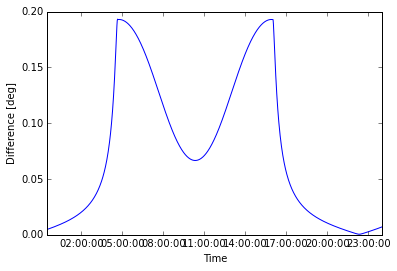

In [132]:
# Compare with vs without atmosphere: 

previous_alt_sun_noatm = get_altitude(previous_sun, previous_times, location)
plt.plot_date(previous_times.plot_date, 
             (previous_alt_sun-previous_alt_sun_noatm).to('degree'), '-')
ax = plt.gca()
ax.set(xlabel='Time', ylabel='Difference [deg]')
plt.show()